<a href="https://colab.research.google.com/github/arthurcito/Manuscrito_PoluicaoCO/blob/main/Manusc03_PoluicaoCO_Fase02_v01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Instalar a API do Earth Engine
!pip install earthengine-api

# Importar e autenticar
import ee
ee.Authenticate()
ee.Initialize(project='ee-arthurcito')


In [ ]:
# Importar bibliotecas auxiliares
import pandas as pd
from datetime import datetime, timedelta

In [ ]:
# Asset das Terras Indígenas de Roraima
ti_collection = ee.FeatureCollection('projects/ee-arthurcito/assets/Manusc03_TerrasIndigenas_PoligonosCompletos_v02')


**ABAIXO**: definir a quantidade de semanas com base em uma semana inicial. Priorizar intervalos até 30 semanas para evitar erros de processamento.

In [ ]:
# Parâmetros da análise
threshold = 0.047  # Limiar de CO
start_date = ee.Date('2018-07-01')
n_weeks = 313


In [ ]:
# Função para calcular a área poluída por feição (TI) para cada semana
def calcular_area_poluidapor_semana(i):
    ini = start_date.advance(i, 'week')
    fim = ini.advance(6, 'day')

    imagem_media = (
        ee.ImageCollection('COPERNICUS/S5P/OFFL/L3_CO')
        .filterDate(ini, fim)
        .select('CO_column_number_density')
        .mean()
        .clip(ti_collection)
    )

    # Máscara: CO >= 0.047
    poluido = imagem_media.gte(threshold)

    # Multiplica pela área de cada pixel (em metros quadrados)
    area_img = poluido.multiply(ee.Image.pixelArea())

    # Reduz por polígono (TI), somando a área com CO acima do limiar
    area_por_ti = area_img.reduceRegions(
        collection=ti_collection,
        reducer=ee.Reducer.sum(),
        scale=1113.2  # resolução da imagem
    ).map(lambda f: f.setGeometry(None).set({ #Aqui, "setGeometry(None)" sucesso para excluir dados de coordenadas da coluna .geom
        'semana_index': i + 1,
        'start_date': ini.format('YYYY-MM-dd'),
        'end_date': fim.format('YYYY-MM-dd'),
        'area_km2': ee.Number(f.get('sum')).divide(1e6)  # converter m² → km²
    }))

    return area_por_ti

Abaixo: Loop 01

In [ ]:
# Executa para as semanas selecionadas e junta tudo
results = []
for i in range(n_weeks):
    areas_semanais = calcular_area_poluidapor_semana(i)
    results.append(areas_semanais)

# Junta tudo em uma única FeatureCollection
resultado_geral = ee.FeatureCollection(results).flatten()


**ABAIXO**: Alterar descrição das Semanas de acordo com número e valor de semanas em "n_weeks"

In [ ]:
# Exporta para uma tabela CSV no Drive (ou pode ser convertido para pandas via client-side)
task = ee.batch.Export.table.toDrive(
    collection=resultado_geral,
    description='Semana01a313_AreaCOLimiar0p047_PorTI_PorSemana', #ALTERAR SEMANAS
    fileFormat='CSV'
)
task.start()

print("Exportação iniciada pelo Google Earth Engine. Verifique a atualização no GEE e em seguida a planilha final no Drive.")


Exportação iniciada pelo Google Earth Engine. Verifique a atualização no GEE e em seguida a planilha final no Drive.


**ABAIXO**: Alterar nome do link do arquivo de acordo com .csv que deseja capturar, observando o range de semanas em "n_weeks".



In [ ]:
# === ABAIXO: CÓDIGO A SER EXECUTADO APÓS O DOWNLOAD DO CSV ===

# 1. Faça upload do CSV no Colab ou conecte o Google Drive:
# from google.colab import drive
# drive.mount('/content/drive')
# csv_path = '/content/drive/MyDrive/Area_CO_maior_igual_0047_por_TI.csv'

# 2. OU faça upload direto do arquivo no Colab
# (Menu lateral esquerdo > Arquivos > Upload)
csv_path = "/content/drive/MyDrive/Semana01a313_AreaCOLimiar0p047_PorTI_PorSemana.csv"  # <- ajuste esse nome se necessário


In [ ]:
# 3. Ler o CSV como DataFrame
df = pd.read_csv(csv_path)

# 4. Inspecionar as colunas disponíveis
print(df.columns)


Index(['system:index', 'area_km2', 'end_date', 'fid', 'semana_index',
       'start_date', 'sum', 'terrai_nom', '.geo'],
      dtype='object')


In [ ]:
# 5. Criar DataFrames agrupados

## Agrupamento por Terra Indígena (área total acumulada)
# Agrupar por Terra Indígena (pelo nome correto)
df_ti = df.groupby('terrai_nom')['area_km2'].sum().reset_index()
df_ti.to_csv("area_total_por_TI.csv", index=False)

## Agrupamento por semana (todas as TIs somadas)
df_semana = df.groupby('start_date')['area_km2'].sum().reset_index()
df_semana = df_semana.rename(columns={'start_date': 'semana'})
df_semana.to_csv("area_total_por_semana.csv", index=False)

# 6. Mostrar os resultados
print("\nÁrea total por TI:")
print(df_ti.head())

print("\nÁrea total por semana:")
print(df_semana.head())



Área total por TI:
  terrai_nom     area_km2
0     Ananás    70.096379
1      Anaro   606.105344
2    Aningal   188.343608
3       Anta   122.249278
4      Araçá  1424.275891

Área total por semana:
       semana   area_km2
0  2018-07-01   0.000000
1  2018-07-08   0.000000
2  2018-07-15   0.000000
3  2018-07-22   0.000000
4  2018-07-29  49.224241


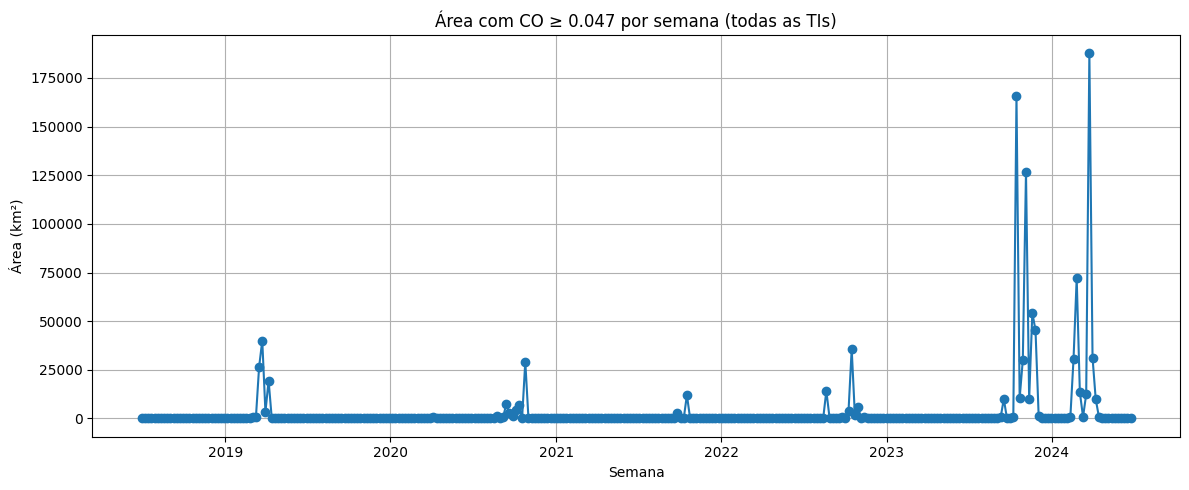

In [ ]:
# 7. (Opcional) Gráfico da série temporal
import matplotlib.pyplot as plt # Import the pyplot module from matplotlib

#Gráfico do agrupamento por SEMANA
plt.figure(figsize=(12,5))
plt.plot(pd.to_datetime(df_semana['semana']), df_semana['area_km2'], marker='o')
plt.title('Área com CO ≥ 0.047 por semana (todas as TIs)')
plt.xlabel('Semana')
plt.ylabel('Área (km²)')
plt.grid(True)
plt.tight_layout()
plt.savefig("serie_temporal_CO.png")
plt.show()

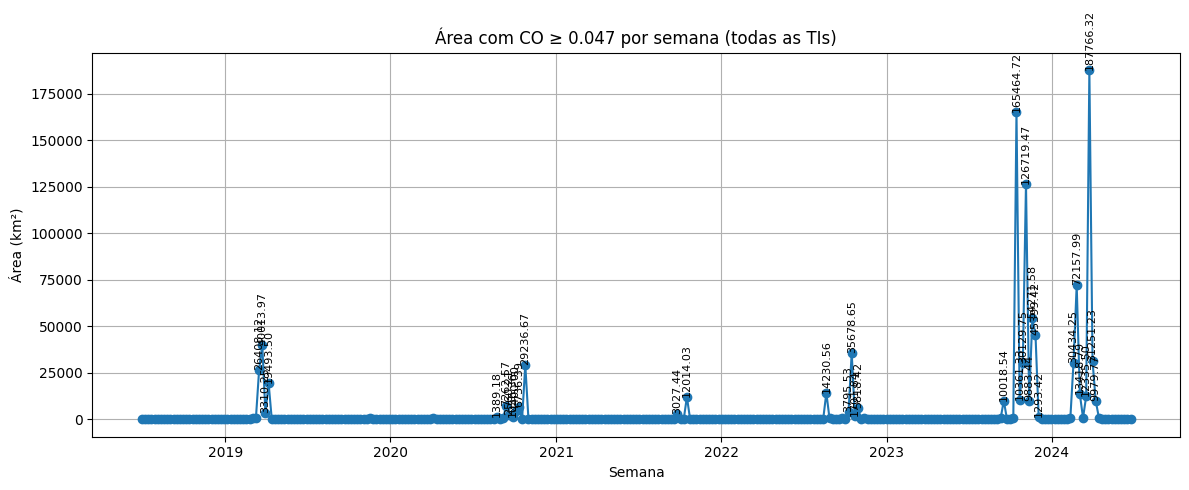

In [ ]:
#####TESTE - Incluir etiquetas nos pontos######
# Similar ao trecho de código acima, mas com a inclusão de um limiar para
# plotar as etiquetas dos valores.

# Certifique-se de que a coluna 'semana' está como datetime
df_semana['semana'] = pd.to_datetime(df_semana['semana'])

# Gráfico da série temporal
plt.figure(figsize=(12,5))
plt.plot(df_semana['semana'], df_semana['area_km2'], marker='o')
plt.title('Área com CO ≥ 0.047 por semana (todas as TIs)')
plt.xlabel('Semana')
plt.ylabel('Área (km²)')
plt.grid(True)



# Adiciona etiquetas apenas para valores > 1000
for i, row in df_semana.iterrows():
    if row['area_km2'] > 1000:
        plt.text(row['semana'], row['area_km2'], f"{row['area_km2']:.2f}",
                 ha='center', va='bottom', rotation=90, fontsize=8)

plt.tight_layout()
plt.savefig("serie_temporal_CO_com_etiquetas.png")
plt.show()


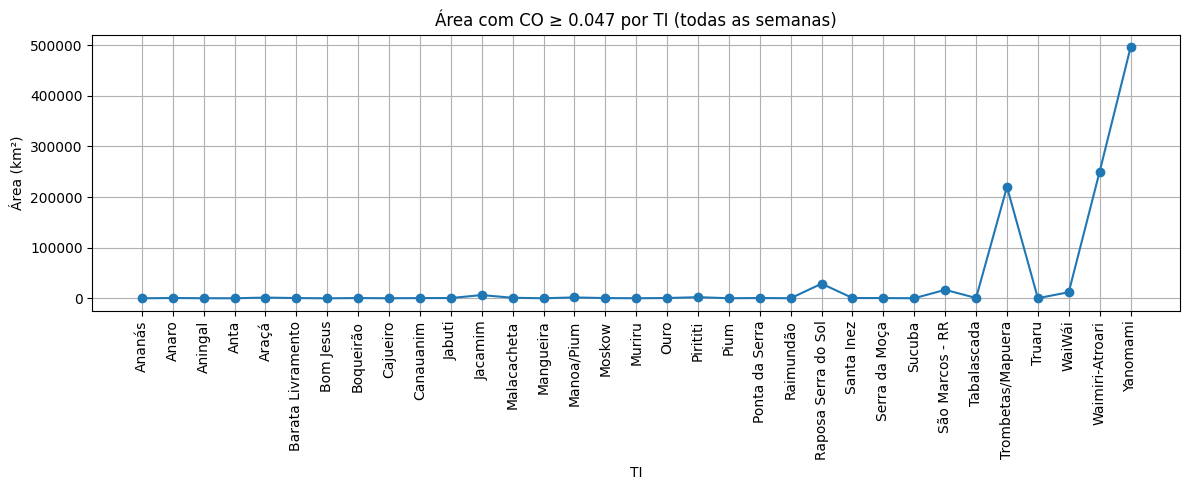

In [ ]:
#Gráfico do agrupamento por TERRA INDÍGENA
plt.figure(figsize=(12,5))
plt.plot(df_ti['terrai_nom'], df_ti['area_km2'], marker='o')
plt.title('Área com CO ≥ 0.047 por TI (todas as semanas)')
plt.xlabel('TI')
plt.xticks(rotation='vertical') # Rotaciona as legendas das feições para a vertical
plt.ylabel('Área (km²)')
plt.grid(True)
plt.tight_layout()
plt.savefig("serie_temporal_CO.png")
plt.show()

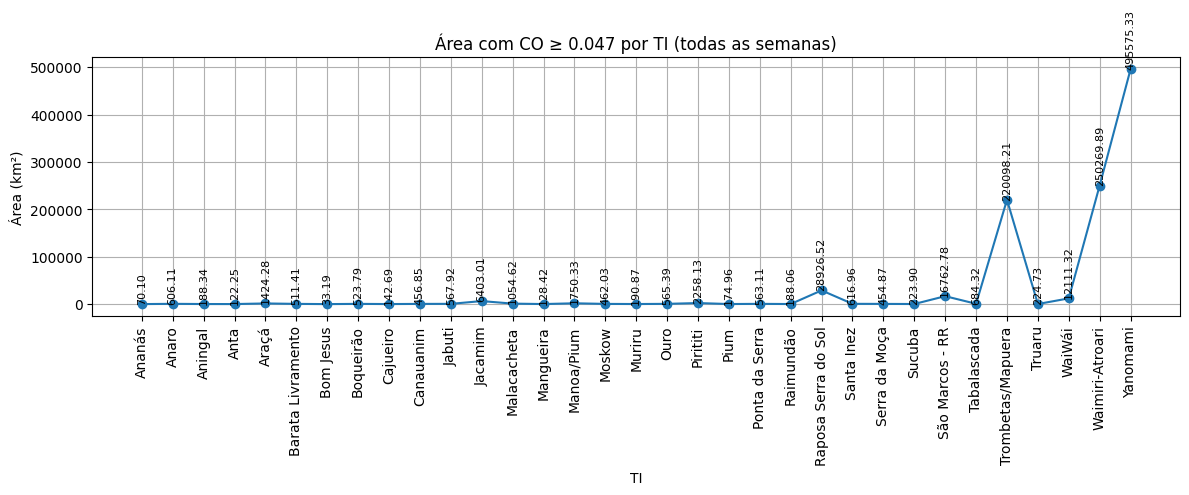

In [ ]:
#####TESTE - Incluir etiquetas nos pontos######
# Similar ao trecho de código acima, mas com a inclusão de um limiar para
# plotar as etiquetas dos valores.

import matplotlib.pyplot as plt

# Gráfico do agrupamento por TERRA INDÍGENA
plt.figure(figsize=(12,5))
plt.plot(df_ti['terrai_nom'], df_ti['area_km2'], marker='o')
plt.title('Área com CO ≥ 0.047 por TI (todas as semanas)')
plt.xlabel('TI')
plt.ylabel('Área (km²)')
plt.xticks(rotation='vertical')  # Rotaciona os nomes das TIs
plt.grid(True)

# Adiciona etiquetas apenas para valores > 0
for i, row in df_ti.iterrows():
    if row['area_km2'] > 0:
        plt.text(i, row['area_km2'], f"{row['area_km2']:.2f}",
                 ha='center', va='bottom', rotation=90, fontsize=8)

plt.tight_layout()
plt.savefig("serie_temporal_CO_por_TI_com_etiquetas.png")
plt.show()
